# Rainfall Prediction

Predict rainfall dataset from https://www.kaggle.com/code/vyacheslavbolotin/ps-s5e3-rainfall-ensemble-of-solutions

In [586]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

load the dataset

In [587]:
df = pd.read_csv("./train.csv")

In [588]:
df.columns = df.columns.str.strip()

In [589]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [590]:
df.isnull().sum().sort_values(ascending=False)

,0
id,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0


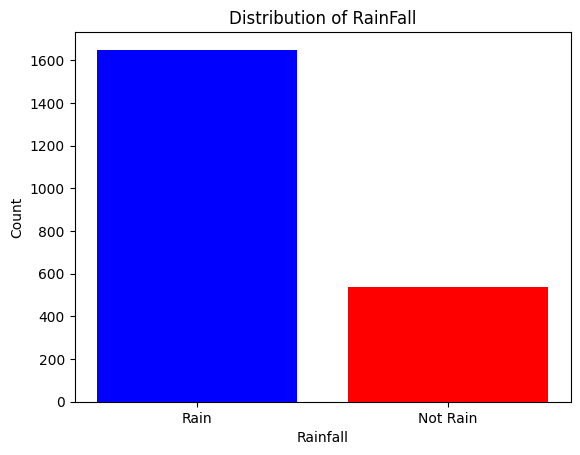

In [591]:
rain = df['rainfall'].sum()
all = df['rainfall'].count()
norain = all-rain

x = np.array(["Rain", "Not Rain"])
y = np.array([rain, norain])
plt.bar(x,y, color=['blue','red'])
plt.xlabel("Rainfall")
plt.ylabel("Count")
plt.title("Distribution of RainFall")
plt.show()

And as see by the distribution the data is a bit imbalanced but in the manageable region.

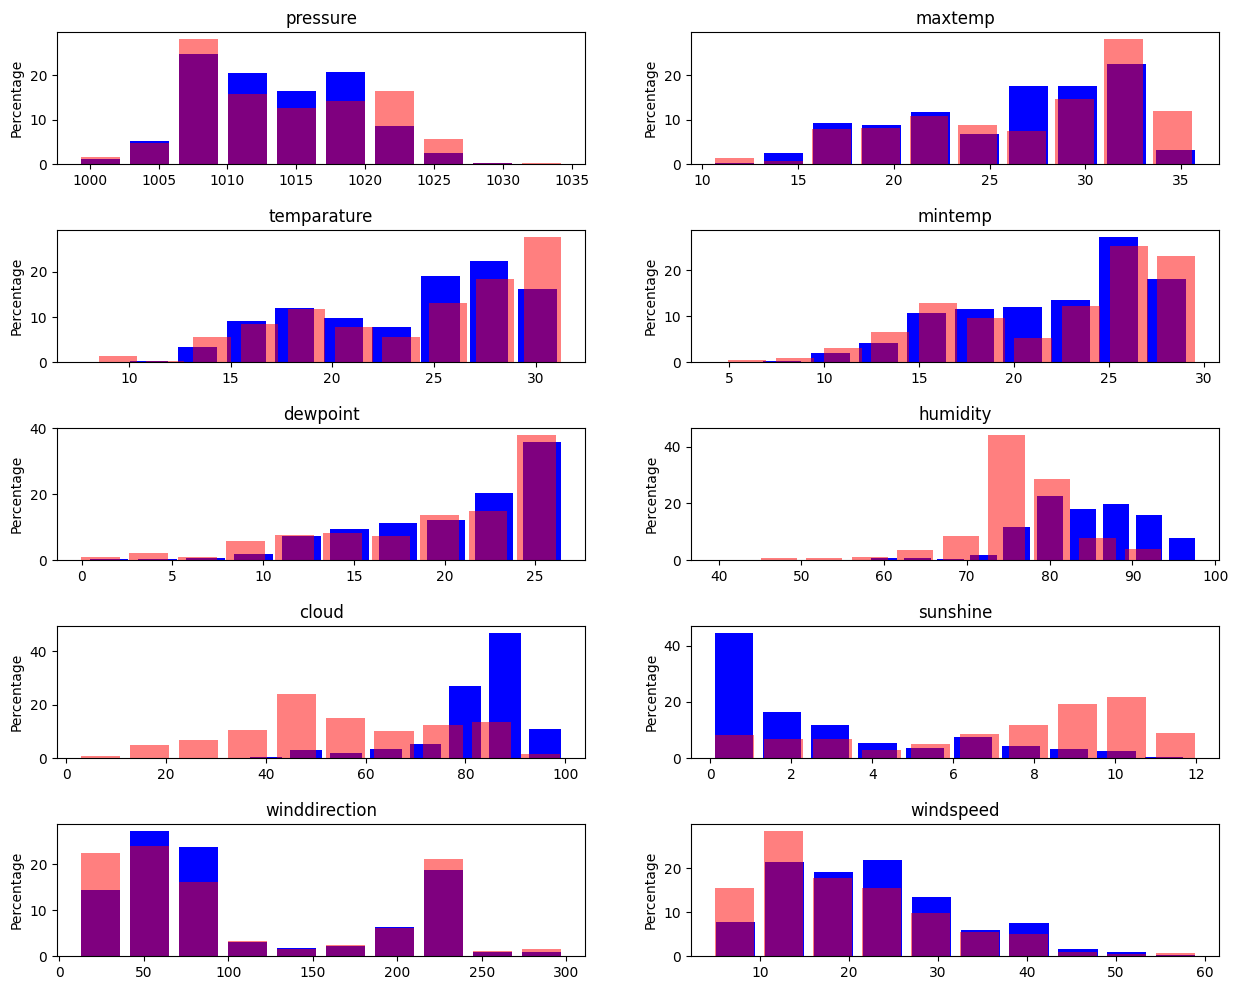

In [592]:
numcolumn = ['pressure','maxtemp','temparature','mintemp','dewpoint','humidity','cloud','sunshine','winddirection','windspeed']

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for c, ax in zip(numcolumn, axs.ravel()):
  raindis = df[df['rainfall'] == 1][c]
  noraindis = df[df['rainfall'] == 0][c]
  ax.set_title(c)
  ax.set_ylabel('Percentage')
  ax.hist(raindis,color='blue',rwidth=0.8,weights=np.ones(len(raindis)) / len(raindis) * 100)
  ax.hist(noraindis,color='red',alpha=0.5,rwidth=0.8, weights=np.ones(len(noraindis)) / len(noraindis) * 100)

plt.show()

and then scatter plot

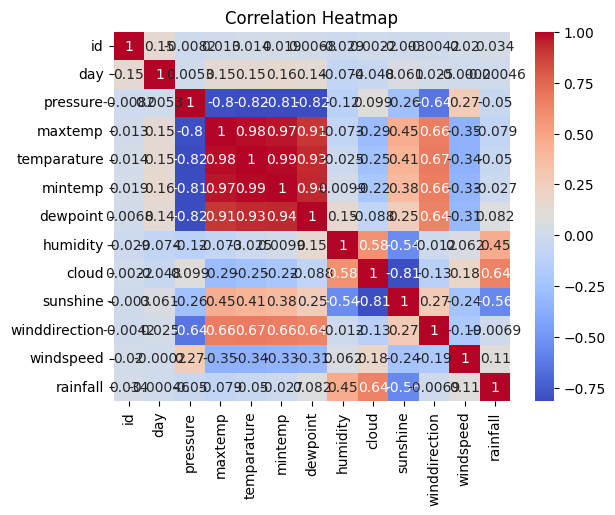

In [593]:
numcolumn.append('rainfall')
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation is almost the same on maxtemp temparature mintemp dewpoint so we should remove all of them except one to avoid overfitting

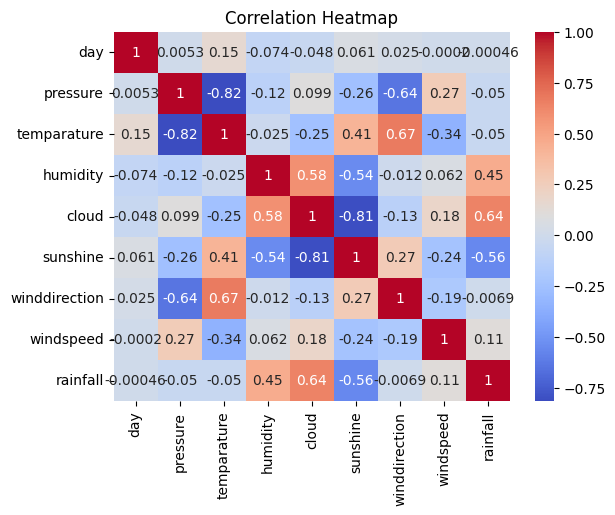

In [594]:
df = df.drop(columns=['maxtemp','mintemp','dewpoint','id'])

corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [595]:
corr['rainfall'].sort_values(ascending=False)

,rainfall
rainfall,1.000000
cloud,0.641191
humidity,0.454213
windspeed,0.111625
day,-0.000462
winddirection,-0.006939
temparature,-0.049660
pressure,-0.049886
sunshine,-0.555287


In [596]:
days_in_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# sum of days in each month
days = [sum(days_in_month[:i+1]) for i in range(len(days_in_month))]

# bin for each month
bins = [0] + days

# label the month
df['month'] = pd.cut(df['day'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], right=True)
df = df.drop(columns=['day'])
df = pd.get_dummies(df, columns=['month'], dtype='int' , drop_first=True)

## Training

After all visualization, let's move to training and first we have to divide train test

In [597]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
import tensorflow as tf

In [598]:
y = df['rainfall']
x = df.drop(columns=['rainfall'])

# train 80 test+val 20
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

# val 50 test 50
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,
    random_state=42,
)

# Result: 80-10-10 split
print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

Train: 1752, Val: 219, Test: 219


In [599]:
# preprocess data by scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [600]:
input_dim = x_train.shape[1]
dropout_rate = 0.3
inputs = Input(shape=(input_dim,))

# layers
x = Dense(256, activation='relu')(inputs)
x = Dropout(dropout_rate)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

# model
model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', AUC()])

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 256)                 │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,641 (190.00 KB)

 Trainable params: 48,641 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

In [601]:
from tensorflow.keras.callbacks import ModelCheckpoint

# save best model
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# train
model.fit(x=x_train,y=y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/200
45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7498 - auc_19: 0.5633 - loss: 0.5752
Epoch 1: val_loss improved from inf to 0.41381, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7511 - auc_19: 0.5959 - loss: 0.5591 - val_accuracy: 0.8813 - val_auc_19: 0.8629 - val_loss: 0.4138
Epoch 2/200
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8539 - auc_19: 0.8757 - loss: 0.3750
Epoch 2: val_loss improved from 0.41381 to 0.38433, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8538 - auc_19: 0.8761 - loss: 0.3737 - val_accuracy: 0.8630 - val_auc_19: 0.8640 - val_loss: 0.3843
Epoch 3/200
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8620 - auc_19: 0.8921 - loss: 0.3350
Epoch 3: val_loss improved from 0.38433 to 0.36862, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8619 - auc_19: 0.8921 - loss: 0.3352 - val_accuracy: 0.8767 - val_auc_19: 0.8616 - 

In [602]:
# load best model
model = tf.keras.models.load_model('best_model.keras')

# evaluate
y_prob = model.predict(x_test).ravel()
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Model Performance Metrics:
Accuracy: 0.8174
Precision: 0.8580
Recall: 0.8910
F1-Score: 0.8742
AUC-ROC: 0.8740

Confusion Matrix:
[[ 40  23]
 [ 17 139]]
